In [1]:
!pip install tensorflow minisom


  Preparing metadata (setup.py) ... done
  Created wheel for minisom: filename=MiniSom-2.3.5-py3-none-any.whl size=12031 sha256=20a22edebd31063b8113bbab436b96f7c5846e187a47b2fc671f0839561ede60
  Stored in directory: /root/.cache/pip/wheels/19/db/95/5e53bc2b88a328217fdf9f2886cafbe86b0df274f4b601f572
Successfully built minisom


# **Google drive Mount**

In [2]:

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# **Data Load**

In [4]:

import pandas as pd
import os
!pip install minisom scikit-learn seaborn


data_path = '/content/drive/MyDrive/20221026_Anik Islam'

train_df = pd.read_csv(os.path.join(data_path, 'train.csv'))
test_df = pd.read_csv(os.path.join(data_path, 'test.csv'))


print("Train Data Columns:")
print(train_df.columns)

print("\nSample Train Data:")
print(train_df.head())


Train Data Columns:
Index(['label', 'pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5',
       'pixel6', 'pixel7', 'pixel8',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=785)

Sample Train Data:
   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8  ...  pixel774  pixel775  pixel776  pixel777  pixel778  pixel779  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0

# **Data Processing**

In [5]:
from sklearn.preprocessing import MinMaxScaler

X = train_df.drop('label', axis=1).values
y = train_df['label'].values

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)


# **Auto Encoder for Latent Embedding**

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

input_dim = X_scaled.shape[1]
encoding_dim = 64

input_layer = Input(shape=(input_dim,))
encoded = Dense(256, activation='relu')(input_layer)
encoded = Dense(128, activation='relu')(encoded)
encoded = Dense(encoding_dim, activation='relu')(encoded)

decoded = Dense(128, activation='relu')(encoded)
decoded = Dense(256, activation='relu')(decoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
encoder = Model(inputs=input_layer, outputs=encoded)

autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X_scaled, X_scaled, epochs=20, batch_size=256, shuffle=True)


Epoch 1/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 0.0975
Epoch 2/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - loss: 0.0336
Epoch 3/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0220
Epoch 4/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0183
Epoch 5/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 0.0159
Epoch 6/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0143
Epoch 7/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0132
Epoch 8/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0122
Epoch 9/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0115
Epoch 10/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0109
Epoch 11/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0104
Epoch 12/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0099
Epoch 13/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.0096
Epoch 14/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.0092
Epoch 15/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 4

# **Latent Embedding**

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

X_encoded = encoder.predict(X_scaled)

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_encoded)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y, palette='tab10', s=10, legend='full')
plt.title("Latent Embedding (Autoencoder + t-SNE)")
plt.show()


1313/1313 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


# **Train SOM (Changing Hyperparameters)**

In [8]:
from minisom import MiniSom
import numpy as np

som_size = 30
som = MiniSom(x=som_size, y=som_size, input_len=encoding_dim, sigma=1.5, learning_rate=0.3)
som.random_weights_init(X_encoded)
som.train_random(X_encoded, 1000)


# **K-means Clustering**

In [9]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, random_state=42)
kmeans_labels = kmeans.fit_predict(X_encoded)


# **Evaluation Metrics **

In [10]:
from sklearn.metrics import silhouette_score, homogeneity_score, completeness_score, v_measure_score
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

print("Silhouette Score:", silhouette_score(X_encoded, kmeans_labels))
print("Homogeneity:", homogeneity_score(y, kmeans_labels))
print("Completeness:", completeness_score(y, kmeans_labels))
print("V-Measure:", v_measure_score(y, kmeans_labels))
print("Adjusted Rand Index (ARI):", adjusted_rand_score(y, kmeans_labels))
print("Adjusted Mutual Info (AMI):", adjusted_mutual_info_score(y, kmeans_labels))


Silhouette Score: 0.0973609
Homogeneity: 0.38945744288813383
Completeness: 0.3942924356647579
V-Measure: 0.3918600256185368
Adjusted Rand Index (ARI): 0.26285015371589093
Adjusted Mutual Info (AMI): 0.3916033777751855


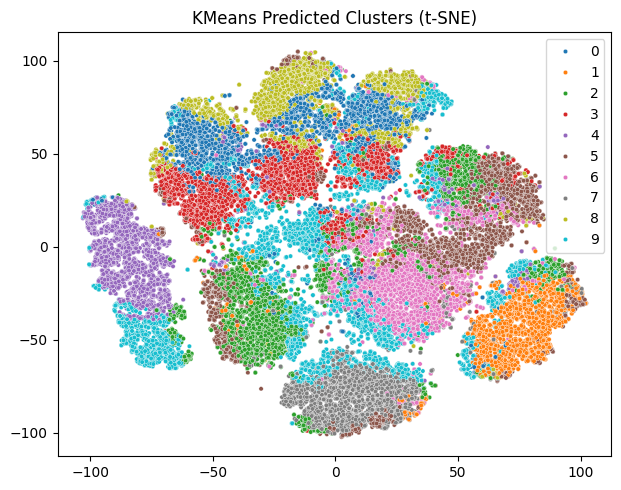

In [12]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 2)
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=kmeans_labels, palette='tab10', s=10)
plt.title("KMeans Predicted Clusters (t-SNE)")

plt.tight_layout()
plt.show()
